   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classif

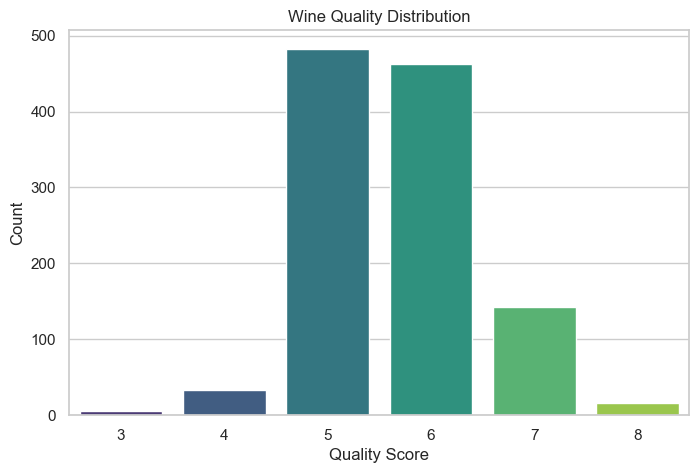

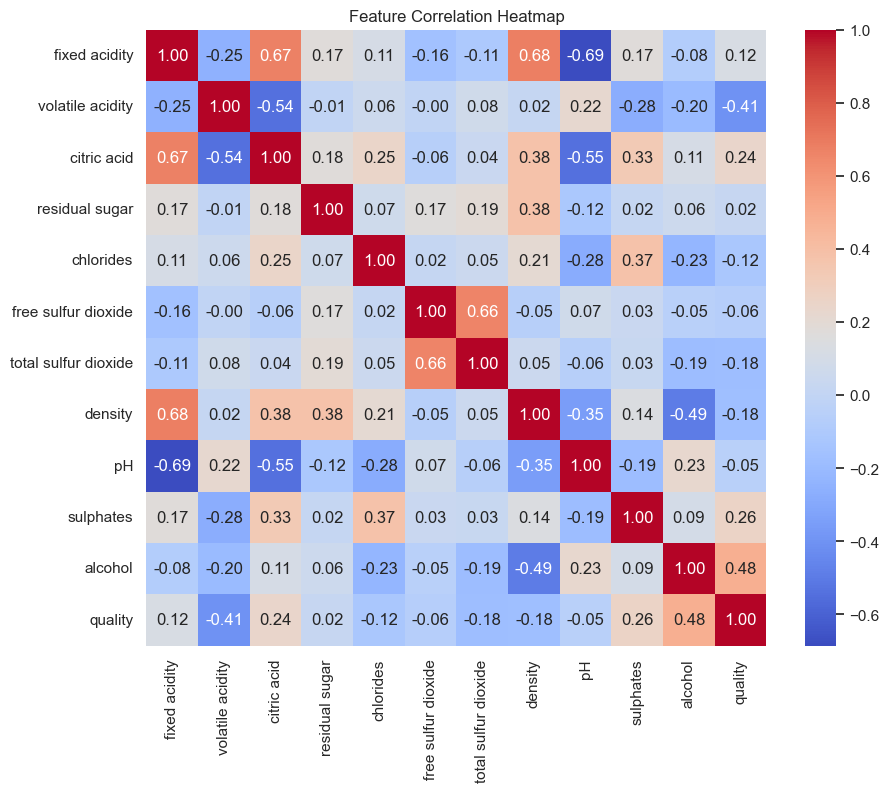

C:\Users\IT SOLUTION\AppData\Local\Temp\ipykernel_10660\2174628623.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feat_names[indices], palette="magma")


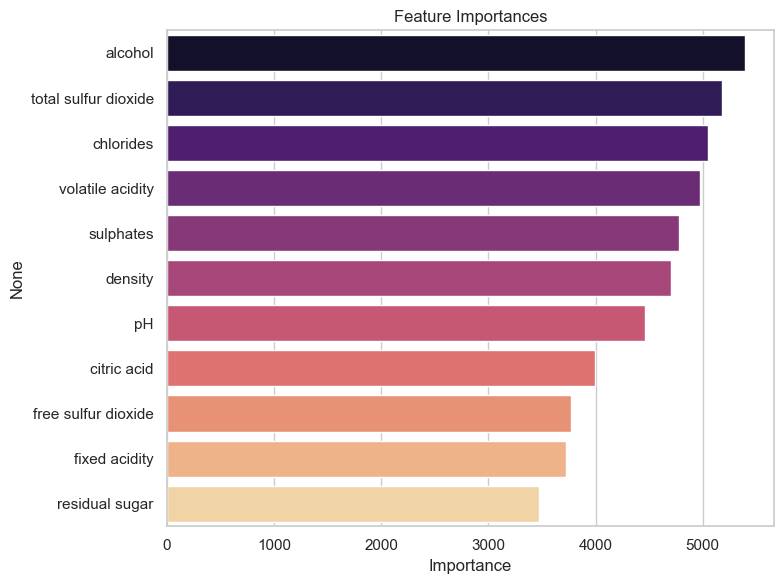

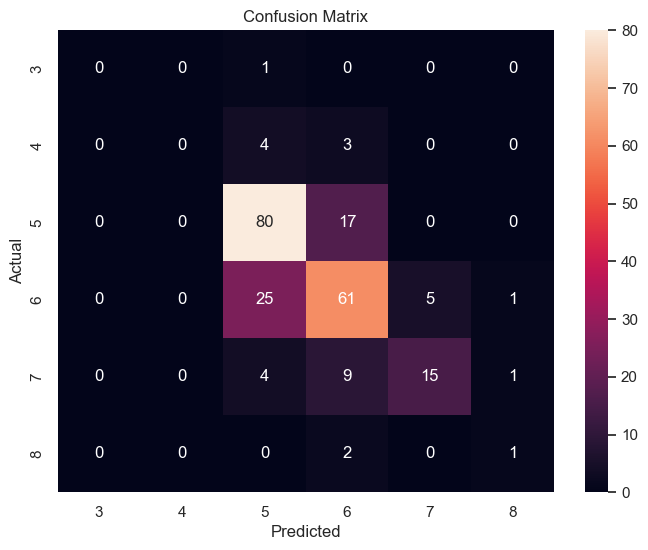

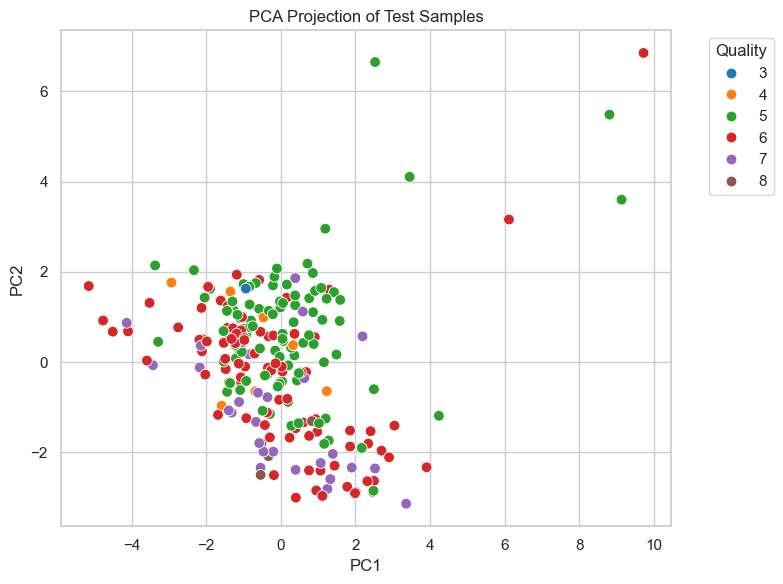

In [4]:
# =========================================
# Wine Quality Dataset - Ordinal Classification
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform

# 1️⃣ Load dataset
df = pd.read_csv("winequality-red.csv", sep=",")  # Comma-separated
df.drop("Id", axis=1, inplace=True)  # Drop unnecessary ID column

# 2️⃣ Inspect dataset
print(df.head())
print(df['quality'].value_counts())

# 3️⃣ Features & target
X = df.drop('quality', axis=1)
y = df['quality']

# 4️⃣ Train-test split (stratified to preserve label distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5️⃣ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6️⃣ LightGBM classifier
lgbm = LGBMClassifier(objective='multiclass', num_class=len(np.unique(y)), random_state=42, n_jobs=-1)

# 7️⃣ Hyperparameter search
param_dist = {
    'n_estimators': randint(200, 800),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 100),
    'colsample_bytree': uniform(0.6, 0.4),
    'subsample': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 2)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train_scaled, y_train)

# 8️⃣ Best model
best_model = search.best_estimator_
print("Best CV accuracy:", search.best_score_)
print("Best params:", search.best_params_)

# 9️⃣ Evaluate on test set
y_pred = best_model.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# =========================================
# Visualizations
# =========================================

sns.set(style="whitegrid")

# 1️⃣ Target distribution
plt.figure(figsize=(8,5))
counts = y.value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, palette="viridis")
plt.title("Wine Quality Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.show()

# 2️⃣ Feature correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# 3️⃣ Feature importance
importances = best_model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=feat_names[indices], palette="magma")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 4️⃣ Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5️⃣ PCA 2D projection
from sklearn.decomposition import PCA
Xpca = PCA(n_components=2, random_state=42).fit_transform(X_test_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=Xpca[:,0], y=Xpca[:,1], hue=y_test, palette="tab10", s=60)
plt.title("PCA Projection of Test Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Quality", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()
